In [75]:
import sys
import os
sys.path.insert(0, '/Users/GA/PycharmProjects/lab/')
from clean_code.operations_with_files import read_fasta
from clean_code.plotting import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from IPython.display import display
from FlowCytometryTools import FCMeasurement
from collections import OrderedDict
import matplotlib.cm as cm
from matplotlib.colors import LogNorm
from scipy.stats import gaussian_kde
%matplotlib inline

In [14]:
def fcs_to_pandas(fcs_folder, fcs_file):
    return pd.DataFrame(FCMeasurement(ID=fcs_file, datafile=fcs_folder+fcs_file)[:])

fcs_folder = '/Users/GA/crg/SMTB_FACS_data/'
fcs_files = [f for f in os.listdir(fcs_folder)]

In [3]:
DataFrames = OrderedDict()

for i in range(len(fcs_files)):
    df = fcs_to_pandas(fcs_folder, fcs_files[i])
    df_name = fcs_files[i]
    dic = {df_name:df}
    DataFrames.update(dic)

In [4]:
# log transform

def log_transform(df):
    for column in df.columns:
        df[column + '_log10'] = (df[column] - df[column].min() + 0.01).apply(np.log10)
    return df

for df_name in DataFrames:
    DataFrames[df_name] = log_transform(DataFrames[df_name])
    
# for df_name in df_noise:
#     df_noise[df_name] = log_transform(df_noise[df_name])   

In [5]:
# Removing the noise

x_channel = 'SSC-A_log10'
y_channel = 'FSC-A_log10'

for df_name in DataFrames:
    DataFrames[df_name] = (DataFrames[df_name])[(DataFrames[df_name][x_channel]) > 3.4]
    DataFrames[df_name] = (DataFrames[df_name])[(DataFrames[df_name][x_channel]) < 5]

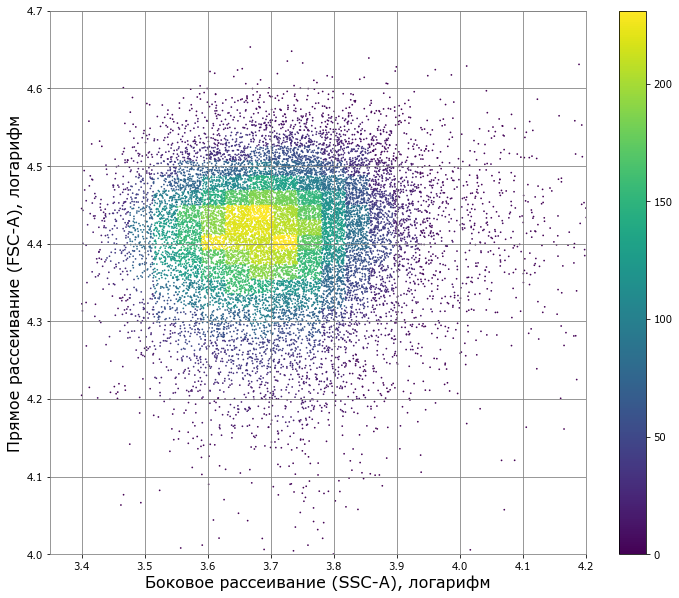

In [80]:
# Plotting scatter plots to see the bacterial populations

fig = plt.figure(figsize=(12, 10))
ax = plt.subplot(111)

x_channel = 'SSC-A_log10'
y_channel = 'FSC-A_log10'
df_name = 'Specimen_001_Plate3_luciferin_well_C5.fcs'

x = DataFrames[df_name][x_channel].values
y = DataFrames[df_name][y_channel].values
density_plot(x, y)
plt.ylim(4, 4.7)
plt.xlim(3.35, 4.2)

font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)

plt.xlabel(u'Боковое рассеивание (SSC-A), логарифм', fontsize=16)
plt.ylabel(u'Прямое рассеивание (FSC-A), логарифм', fontsize=16)

plt.grid()
xgrid = ax.get_xgridlines()
ygrid = ax.get_ygridlines()
for i in xgrid:
    i.set_color('grey')
for i in ygrid:
    i.set_color('grey')
ax.spines['left'].set_color('grey')
ax.spines['right'].set_color('grey')
ax.spines['top'].set_color('grey')
ax.spines['bottom'].set_color('grey')

plt.colorbar()

plt.savefig('density_plot_rus.pdf')

# plt.tight_layout()

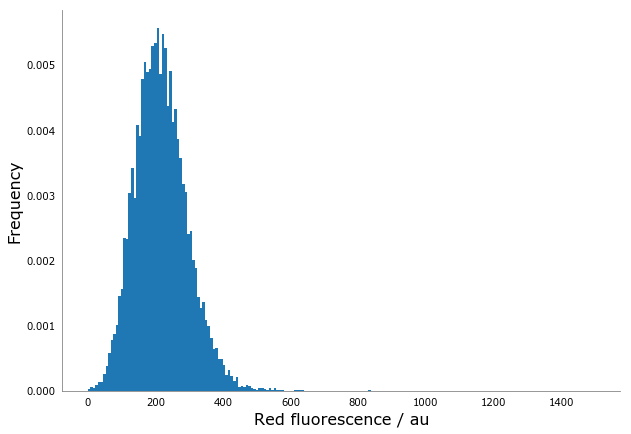

In [91]:
plot_better(width=10, height=7, grid='')
ax = plt.subplot(111)

x_channel = 'PE-Texas Red-A'
df_name = 'Specimen_001_Plate3_luciferin_well_C5.fcs'

min_val = DataFrames[df_name][x_channel].min()
hist_data = np.array((DataFrames[df_name][x_channel]).apply(lambda x: x - min_val))
mean = np.mean(hist_data)
std = np.std(hist_data)
filtered = [x for x in hist_data if (x > mean-2*std) or (x < mean+2*std)]
filtered = np.array(filtered)
max_val = filtered.max()
bins = np.linspace(0, 1500, num = 200)

ax.hist(filtered, bins, normed=True)
plt.xlabel('Red fluorescence / au', fontsize=16)
plt.ylabel('Frequency', fontsize=16)

plt.savefig('Histogram_plate3_eng.pdf')



    
    

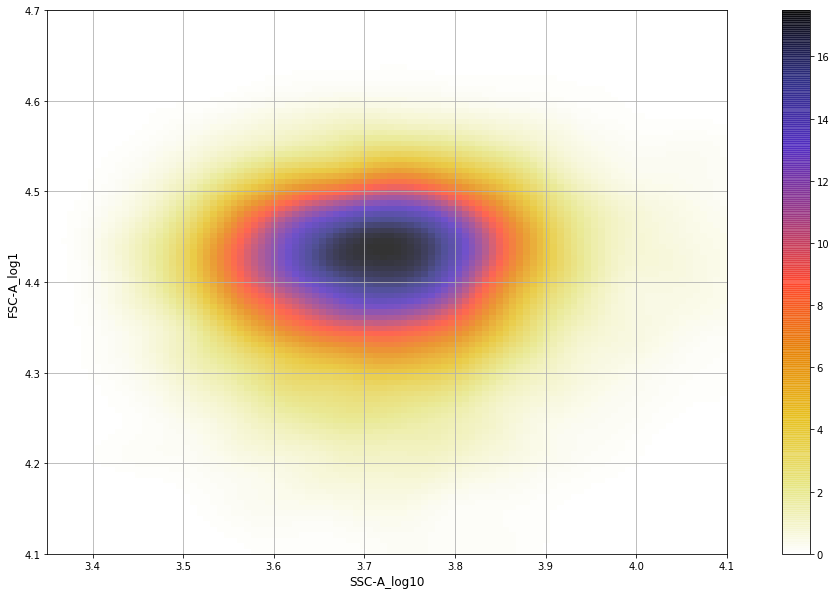

In [60]:
x_channel = 'SSC-A_log10'
y_channel = 'FSC-A_log10'
df_name = 'Specimen_001_Plate3_luciferin_well_C5.fcs'

x = np.array(DataFrames[df_name][x_channel].values)
y = np.array(DataFrames[df_name][y_channel].values)

points = np.vstack([x, y])

npts = len(x)         # number of sample points
bins = 100          # number of bins in density maps
threshold = 0.5    # density threshold for scatter plot

# initialize figure
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(111)
plt.ylim(4.1, 4.7)
plt.xlim(3.35, 4.1)
plt.xlabel('SSC-A_log10', fontsize=12)
plt.ylabel('FSC-A_log1', fontsize=12)
plt.grid()

# perform kernel density estimate
kde = gaussian_kde(points)
z = kde(points)

# mask points above density threshold
x = np.ma.masked_where(z > threshold, x)
y = np.ma.masked_where(z > threshold, y)

# get bounds from axes
xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()

# prepare grid for density map
xedges = np.linspace(xmin, xmax, bins)
yedges = np.linspace(ymin, ymax, bins)
xx, yy = np.meshgrid(xedges, yedges)
gridpoints = np.array([xx.ravel(), yy.ravel()])

# compute density map
zz = np.reshape(kde(gridpoints), xx.shape)

# plot density map
im = ax.imshow(zz, cmap='CMRmap_r', interpolation='nearest',
               origin='lower', extent=[xmin, xmax, ymin, ymax], alpha=0.8)

# show
fig.colorbar(im)